#Введение

В исходных данных содержится информация о продажах ~440000 автомобилей с аукционов, которые будут использоваться в качестве обучающих данных (train.csv) и ~110000 будут использоваться в качестве тестовых данных (test.csv).

Задача - разработать модель для предсказания стоимости продажи автомобиля на вторичном рынке.

В качестве метрики оценки качества моделей будет использоваться MAPE (Mean Absolute Percentage Error)

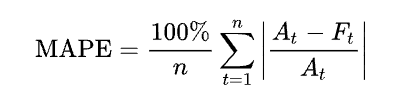

Описание полей данных:

'year' - год производства

'make' - производитель

'model' - модель

'trim' - модификация

'body' - тип кузова

'transmission' - тип КПП

'vin' - идентификатор (вин)

'state' - штат регистрации

'condition' - состояние по шкале (1-5)

'odometer' - пробег в милях

'color' - цвет кузова

'interior' - цвет интерьера

'seller' - продавец

'sellingprice' - стоимость продажи

'saledate' - дата продажи

#Блок инсталяции

In [ ]:
#установка phik
! pip install phik
#установка кэтбуста
! pip install catboost
# установка optuna 
! pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


#Блок импорта библиотек

In [ ]:
# импортируем pandas для работы с таблицами
import pandas as pd
# подключаем библиотеки визуализации
import seaborn as sns
import matplotlib.pyplot as plt
# реализуем возможность вывода всех столбцов на экран
pd.set_option('display.max_columns', None)
#реализуем возможность вывода всех строк на экран
pd.set_option('display.max_rows', None)
# импортируем библиотеку для математических операций
import numpy as np
#импортируем phik
import phik
from phik import resources, report
# обработка ворнингов
import warnings
warnings.filterwarnings("ignore")
# импорт optuna для подбора гиперпараметров
import optuna
# импорт метрик
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# импорт выборок
from sklearn.model_selection import train_test_split
# импорт кэтбуста
from catboost import cv
from catboost import CatBoostRegressor, Pool
# параметр Random State
rs = 42

#Знакомство с данными

Загружаем данные:

In [ ]:
df = pd.read_csv(r"C:\Users\1\Desktop\Проект Kaggle/train.csv") # данные для обучения модели
df_test = pd.read_csv(r"C:\Users\1\Desktop\Проект Kaggle/test.csv") # данные для тестирования модели

Смотрим размеры фреймов:

In [ ]:
display(df.shape)
display(df_test.shape)

(440236, 15)

(110060, 14)

##Количество пропусков в столбцах

In [ ]:
display(df.isna().mean().sort_values(ascending=False))

transmission    0.116894
body            0.023608
condition       0.021364
trim            0.018938
model           0.018451
make            0.018270
color           0.001331
interior        0.001331
odometer        0.000157
year            0.000000
vin             0.000000
state           0.000000
seller          0.000000
sellingprice    0.000000
saledate        0.000000
dtype: float64

In [ ]:
display(df_test.isna().mean().sort_values(ascending=False))

transmission    0.118226
body            0.023569
condition       0.021615
trim            0.019208
model           0.018890
make            0.018726
color           0.001436
interior        0.001436
odometer        0.000173
year            0.000000
vin             0.000000
state           0.000000
seller          0.000000
saledate        0.000000
dtype: float64

#Замена некорректных значений


##Преобразуем пропуски в строку

In [ ]:
list_str = ['color','interior','model','trim','body','transmission']
for x in list_str:
  df[x] = df[x].astype('str')
  df_test[x] = df_test[x].astype('str')
  df[x] = df[x].fillna('empty')
  df_test[x] = df_test[x].fillna('empty')

##Color/Interior

Через метод unique понимаем, что в столбцах цвета кузова и интерьера есть знак "-" который по существу обозначает пропуски. Корректируем:

In [ ]:
# меняем символ "—" на пропуск 
df.loc[df['color']=='—','color'] = 'empty'
df_test.loc[df_test['color']=='—','color'] = 'empty'
df.loc[df['interior']=='—','interior'] = 'empty'
df_test.loc[df_test['interior']=='—','interior'] = 'empty'
# укрупняем цвет white включая в него off-white
df = df.replace({'color':{'off-white':'white'},'interior':{'off-white':'white'}})
df_test = df_test.replace({'color':{'off-white':'white'},'interior':{'off-white':'white'}})

В тренировочном датасете есть значения, которых нет в трейне. Зачем модели учить взаимосвязи между цветами, марками и моделями, которые её не будут спрашивать? Далее по такой же логике значения, которых не существует в трейне будут удалены.

In [ ]:
result_unique_color_list = list(set(df['color'].unique())-set(df_test['color'].unique()))
display(result_unique_color_list)
result_unique_interior_list = list(set(df['interior'].unique())-set(df_test['interior'].unique()))
display(result_unique_interior_list)

[]

[]

##Make

Через метод unique приводим названия марок к единому порядку:

In [ ]:
# устранение ошибок в названиях через словарь
df = df.replace({'make':{'mercedes-benz':'mercedes','mercedes-b':'mercedes','vw':'volkswagen','dodge tk':'dodge','ford truck':'ford','mazda tk':'mazda','gmc truck':'gmc','landrover':'land rover'}})
df_test = df_test.replace({'make':{'mercedes-benz':'mercedes','mercedes-b':'mercedes','vw':'volkswagen','dodge tk':'dodge','ford truck':'ford','mazda tk':'mazda','gmc truck':'gmc','hyundai tk':'hyundai','ford tk':'ford','landrover':'land rover','chev truck':'chevrolet','chevy':'chevrolet'}})

In [ ]:
df['make'] = df['make'].str.lower() # приводим к нижнему регистру
df['make'] = df['make'].str.strip() # убирает пробелы
df_test['make'] = df_test['make'].str.lower() # приводим к нижнему регистру
df_test['make'] = df_test['make'].str.strip() # убирает пробелы

Проверим, каких марок машин нет в тестовом датасете:

In [ ]:
result_unique_make_list = list(set(df['make'].unique())-set(df_test['make'].unique()))
display(result_unique_make_list)

['lamborghini', None, 'dot', 'airstream']

Марки 'dot', 'airstream' и 'lamborghini' не встречаются в тестовом датасете. Их можно удалить из df

In [ ]:
df = df[(df.make != 'dot') & (df.make != 'airstream') & (df.make != 'lamborghini')]

In [ ]:
df['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai', None,
       'buick', 'chevrolet', 'honda', 'acura', 'cadillac', 'gmc', 'saab',
       'dodge', 'mercedes-benz', 'toyota', 'volkswagen', 'bmw',
       'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep', 'lexus',
       'mercedes', 'scion', 'fiat', 'suzuki', 'mazda', 'volvo', 'audi',
       'mini', 'isuzu', 'mitsubishi', 'smart', 'porsche', 'land rover',
       'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley', 'fisker',
       'maserati', 'tesla', 'rolls-royce', 'ferrari', 'plymouth', 'geo',
       'aston martin', 'daewoo'], dtype=object)

##Model

In [ ]:
df['model'] = df['model'].str.lower() # приводим к нижнему регистру
df['model'] = df['model'].str.strip() # убирает пробелы
df_test['model'] = df_test['model'].str.lower() # приводим к нижнему регистру
df_test['model'] = df_test['model'].str.strip() # убирает пробелы

In [ ]:
len(df['model'].unique())

838

In [ ]:
result_unique_model_list = list(set(df['model'].unique())-set(df_test['model'].unique()))
df = df[df.model.isin(result_unique_model_list) == False ]
display(len(result_unique_model_list))

103

In [ ]:
len(df['model'].unique())

735

##Trim

In [ ]:
df['trim'] = df['trim'].str.lower() # приводим к нижнему регистру
df['trim'] = df['trim'].str.strip() # убирает пробелы
df_test['trim'] = df_test['trim'].str.lower() # приводим к нижнему регистру
df_test['trim'] = df_test['trim'].str.strip() # убирает пробелы

In [ ]:
len(df['trim'].unique()) # количество уникальных моделей до обработки

1790

In [ ]:
result_unique_trim_list = list(set(df['trim'].unique())-set(df_test['trim'].unique())) # смотрим каких значений нет в df_test
df = df[df.trim.isin(result_unique_trim_list) == False ] # возвращает df только с теми значениями, которые есть и в df_test тоже 
display(len(result_unique_trim_list)) # смотрим насколько должно уменьшиться количество уникальных моделей

391

In [ ]:
len(df['trim'].unique()) # 1839 - 440 = 1399 - значит код выше работает верно

1399

##Body

In [ ]:
df['body'] = df['body'].str.lower() # приводим к нижнему регистру
df['body'] = df['body'].str.strip() # убирает пробелы
df_test['body'] = df_test['body'].str.lower() # приводим к нижнему регистру
df_test['body'] = df_test['body'].str.strip() # убирает пробелы

По существу, группы кузовов можно укрупнить следующим образом:

In [ ]:
def body_types_group(x):
    if 'sedan' in x:
        return 'sedan'
    elif 'van' in x:
        return 'van'
    elif 'coupe' in x:
      return 'coupe'
    elif 'cab' in x:
      return 'cab'
    elif 'wagon' in x:
      return 'wagon'
    elif 'convertible' in x:
      return 'convertible'
    return x
df['body'] = df['body'].apply(body_types_group)
df_test['body'] = df_test['body'].apply(body_types_group)

In [ ]:
df = df.replace({'body':{'koup':'coupe'}})
df_test = df_test.replace({'body':{'koup':'coupe'}})

In [ ]:
result_unique_body_list = list(set(df['body'].unique())-set(df_test['body'].unique()))
display(result_unique_body_list)

[]

##Transmission

Заменим ручную коробку на 0, а автоматическую на 1

In [ ]:
df = df.replace({'transmission':{'automatic': 1,'manual': 0}})
df_test = df_test.replace({'transmission':{'automatic': 1,'manual': 0}})

##Возвращаем пропуски

Для работы с категориальными переменными мы заменили в категориальных столбцах тип данных на str, а пропуски заменили словом 'empty'. Теперь можно вернуть всё обратно:

In [ ]:
df = df.replace(['empty'],np.nan) # меняем значения обратно на nan
df_test = df_test.replace(['empty'],np.nan) # меняем значения обратно на nan
df = df.replace(['nan'],np.nan) # меняем значения обратно на nan
df_test = df_test.replace(['nan'],np.nan) # меняем значения обратно на nan

#Создание вспомогательного столбца

##Возраст автомобиля

Для людей (и для алгоритмов) может быть полезно знать возраст автомобиля

In [ ]:
df['saledate'] = pd.to_datetime(df['saledate'], utc=True) # приводим дату продажи к формату datetime uts
df_test['saledate'] = pd.to_datetime(df_test['saledate'], utc=True) # приводим дату продажи к формату datetime uts
df['sale_year'] = df['saledate'].dt.year # извлекаем год из даты продажи в df  
df_test['sale_year'] = df_test['saledate'].dt.year # извлекаем год из даты продажи в df_test
df['age_car'] = df['sale_year'] - df['year'] # добавляем столбец с возрастом автомобиля в годах
df_test['age_car'] = df_test['sale_year'] - df_test['year'] # добавляем столбец с возрастом автомобиля в годах

Теперь, когда у нас есть возраст автомобиля, знать дату и год продажи нет необходимости:

In [ ]:
df.drop(['saledate', 'sale_year'],axis=1,inplace=True)
df_test.drop(['saledate', 'sale_year'],axis=1,inplace=True)

In [ ]:
df.loc[df['age_car'] < 0, 'age_car'] = 0
df_test.loc[df_test['age_car'] < 0, 'age_car'] = 0

In [ ]:
drop_list = df[(df['age_car']==0)&(df['odometer']>16000)==True].index.tolist()
df = df.drop(index=drop_list).reset_index(drop=True)

#Удаление "лишних" фичей

VIN номер уникален для каждого автомобиля. И хотя он и содержит в себе информацию о марке, типе кузова, двигателе и много чего еще, в рамках 50+ уникальных марок выявить структуру VIN для каждой конкретной будет проблематично. А т.к я не успел прикрутить vin-decoder, откажемся от этого столбца. Год нам больше не нужен, т.к у нас уже есть столбец возраста автомобиля. 

In [ ]:
df.drop(['year', 'vin', 'seller'], axis= 1 , inplace= True) # удаляем ненужные столбцы
df_test.drop(['year', 'vin', 'seller'], axis= 1 , inplace= True) # удаляем ненужные столбцы

In [ ]:
df.head()

,make,model,trim,body,transmission,state,condition,odometer,color,interior,sellingprice,age_car
0,ford,edge,sel,suv,1.0,md,4.2,111041.0,black,black,12500,4
1,ford,fusion,se,sedan,1.0,mo,3.5,31034.0,black,black,14500,1
2,nissan,sentra,2.0 sl,sedan,1.0,nj,2.2,35619.0,black,black,9100,3
3,hummer,h2,base,suv,1.0,tx,2.8,131301.0,gold,beige,13300,12
4,ford,fusion,sel,sedan,1.0,md,2.0,127709.0,black,black,1300,8


#Обработка экстремальных значений (выбросов) в df

In [ ]:
def iqr(data, column): # введем ф-ю, описывающую параметры значений столбца
    """
    Функция подсчитывает диапазон с учетом межквартильного размаха
    """
    print(data[column].describe())
    iqr = data[column].describe()[6] - data[column].describe()[4]
    low_bond = data[column].describe()[4] - 1.5 * iqr
    if low_bond < 0:
        low_bond = data[column].describe()[3]
    upper_bond = data[column].describe()[6] + 1.5 * iqr
    print('Нижняя граница:', low_bond)
    print('Верхняя граница:', upper_bond)
# возьмем часть из функции выше, но для возвращения нижней границы усов, это понадобится при удалении лишних значений
def low_bond(data, column): 
    iqr = data[column].describe()[6] - data[column].describe()[4]
    low_bond = data[column].describe()[4] - 1.5 * iqr
    if low_bond < 0:
        low_bond = data[column].describe()[3]
    return low_bond
# введем аналогичную функцию для верхней границы усов
def upper_bond(data, column): 
    iqr = data[column].describe()[6] - data[column].describe()[4]
    upper_bond = data[column].describe()[6] + 1.5 * iqr
    return upper_bond

##Sellingprice

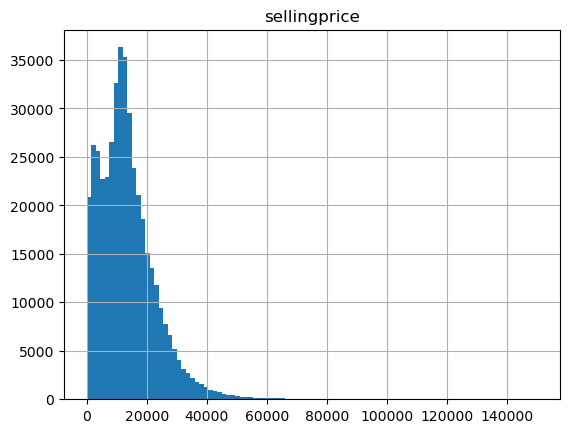

count    434881.000000
mean      13514.747669
std        9647.802863
min           1.000000
25%        6800.000000
50%       12100.000000
75%       18100.000000
max      230000.000000
Name: sellingprice, dtype: float64
Нижняя граница: 1.0
Верхняя граница: 35050.0


None

In [ ]:
df.hist(column = 'sellingprice',bins=100,range=(0,150000))
plt.show()
display(iqr(df, 'sellingprice'))

Попробуем обрезать так:

In [ ]:
display(np.percentile(df['sellingprice'],5)) # процентиль для определения нижнего сегмента выбросов
display(np.percentile(df['sellingprice'],99)) # процентиль для определения верхнего сегмента выбросов

1500.0

44250.0

In [ ]:
def price_type(row):
    if row['sellingprice'] >= 200000:
        return 'luxury'
    elif row['sellingprice'] <= 1500:
        return 'low cost'
    elif row['sellingprice'] > 1500 and row['sellingprice'] < 200000:
      return 'common'
# создадим категорию автомобиля по его цене
df['price_type'] = df.apply(price_type, axis=1)

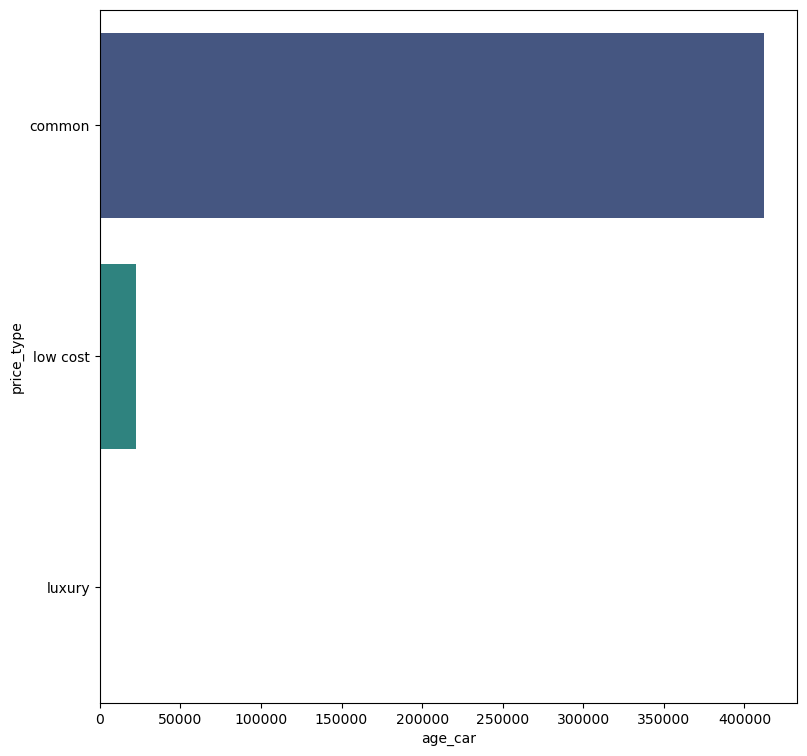

In [ ]:
plt.figure(figsize=(9,9))
sns.barplot(data=df.groupby('price_type')[['age_car']].count().reset_index(),
            y = 'price_type',
            x = 'age_car',
            palette='viridis')
plt.show()
df.drop(['price_type'], axis= 1 , inplace= True) # удаляем вспомогательный столбец

In [ ]:
df = df[(df.sellingprice > 1500)&(df.sellingprice < 200000)] # больше 1500 но меньше 200000

##Odometer

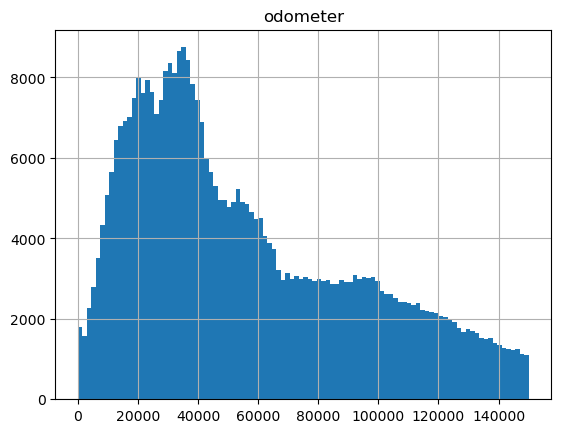

count    412123.000000
mean      63635.077283
std       48057.449648
min           1.000000
25%       27649.500000
50%       49298.000000
75%       92293.000000
max      999999.000000
Name: odometer, dtype: float64
Нижняя граница: 1.0
Верхняя граница: 189258.25


None

In [ ]:
df.hist(column = 'odometer',bins=100,range=(0,150000))
plt.show()
display(iqr(df, 'odometer'))

In [ ]:
df = df[df.odometer < 200000] # остались значения меньше 200000

#Заполнение пропущенных значений

##Odometer

In [ ]:
df['odometer'] = df.groupby('age_car')['odometer'].apply(lambda x: x.fillna(x.mean()))
df_test['odometer'] = df_test.groupby('age_car')['odometer'].apply(lambda x: x.fillna(x.mean()))

##Condition

In [ ]:
df['condition'] = df.groupby('age_car')['condition'].apply(lambda x: x.fillna(x.mean()))
df_test['condition'] = df_test.groupby('age_car')['condition'].apply(lambda x: x.fillna(x.mean()))

##Transmission

In [ ]:
df['transmission'] = df['transmission'].fillna(1)
df_test['transmission'] = df_test['transmission'].fillna(1)

#Конвертирование типов фичей

In [ ]:
df_test.head()

,make,model,trim,body,transmission,state,condition,odometer,color,interior,age_car
0,cadillac,cts,base,sedan,1.0,ca,2.7,116970.0,silver,black,10
1,gmc,savana cargo,2500,van,1.0,pa,4.4,6286.0,white,gray,1
2,nissan,murano,s,suv,1.0,oh,4.6,11831.0,gray,black,2
3,chevrolet,impala,ls fleet,sedan,1.0,fl,2.3,57105.0,silver,black,2
4,nissan,titan,sv,cab,1.0,tn,2.9,31083.0,black,black,2


In [ ]:
df['transmission'] = df['transmission'].astype('int')
df_test['transmission'] = df_test['transmission'].astype('int')
string_list = ['make','model','trim','body','state','color','interior']
for x in string_list:
  df[x] = df[x].astype('string')
  df_test[x] = df_test[x].astype('string')

In [ ]:
df_test.head()

,make,model,trim,body,transmission,state,condition,odometer,color,interior,age_car
0,cadillac,cts,base,sedan,1,ca,2.7,116970.0,silver,black,10
1,gmc,savana cargo,2500,van,1,pa,4.4,6286.0,white,gray,1
2,nissan,murano,s,suv,1,oh,4.6,11831.0,gray,black,2
3,chevrolet,impala,ls fleet,sedan,1,fl,2.3,57105.0,silver,black,2
4,nissan,titan,sv,cab,1,tn,2.9,31083.0,black,black,2


##Other

In [ ]:
df = df.dropna(subset=['make','model','trim'])
df = df.fillna('empty').copy()
df_test = df_test.fillna('empty').copy()

#Optuna + CatBoost

##Фичи

In [ ]:
X = ['make', 'model',	'trim',	'body',	'transmission',	'state', 'condition', 'odometer', 'color',	'interior', 'age_car'] # список всех фичей кроме целевого
cat_features = ['make','model','trim','body','state','color','interior'] # категориальные фичи
y = ['sellingprice'] # целевая фича

##Optuna

###Выборки для Optuna

In [ ]:
#SAMPLE_RATE = 0.4 # какую часть данных брать для оптуны (сейчас 40%)
#RANDOM_SEED = rs # параметр рандом
#EARLY_STOPPING_ROUND = 100 # если больше 100 итераций ничего не улучшается - конец обучения

#train_sample = df.sample(int(df.shape[0] * SAMPLE_RATE)) # берем часть данных 

#X = train_sample[X] # все фичи из кэтбуста
#y = train_sample[y] # таргет из кэтбуста

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED) # делаем выборки ТОЛЬКО ДЛЯ ОПТУНЫ
#X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED) # ДОБАВЛЯЕТСЯ EVAL 

###Гиперпараметры CatBoost для подбора Optuna

In [ ]:
#def objective(trial):
#    param = {}
#    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
#    param['depth'] = trial.suggest_int('depth', 9, 15)
#    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
#    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
#    param['grow_policy'] = 'Depthwise'
#    param['iterations'] = 10000
#    param['use_best_model'] = True
#    param['eval_metric'] = 'MAPE'
#    param['od_type'] = 'iter'
#    param['od_wait'] = 20
#    param['random_state'] = RANDOM_SEED
#    param['logging_level'] = 'Silent'
#    param['cat_features'] = cat_features
    
#    regressor = CatBoostRegressor(**param)

#    regressor.fit(X_train.copy(), y_train.copy(),
#                  eval_set=[(X_eval.copy(), y_eval.copy())],
#                  early_stopping_rounds=EARLY_STOPPING_ROUND)
#    loss = mean_absolute_percentage_error(y_valid, regressor.predict(X_valid.copy()))
#    return loss

###Обучение Optuna

In [ ]:
#%%time
#study = optuna.create_study(study_name=f'catboost-seed{rs}')
#study.optimize(objective, n_trials=10000, n_jobs=-1, timeout=24000)

In [ ]:
#study.best_value

In [ ]:
#study.best_params

##CatBoost

###Пулы

In [ ]:
train_data = Pool(data=df[X], label=df[y], cat_features=cat_features)
test_data = Pool(data = df_test[X], cat_features= cat_features)

###Параметры из Optuna в CatBoost

'learning_rate': 0.018000000000000002, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 9 with value: 0.11905462733459295.

In [ ]:
params = {'eval_metric':'MAPE', # максимизация метрики
          'loss_function': 'RMSE', # функция потерь
          'random_seed': rs, # параметр рандома
          'verbose': 1000, # вывод итераций (визуал) - каждую 1000
          'iterations': 9999, # количество циклов обучения
          'learning_rate': 0.018000000000000002, # скорость обучения
          'early_stopping_rounds': 200,
          'depth': 9,
          'l2_leaf_reg': 1.0,
          'min_child_samples': 16} # если 100 итераций ничего не улучшается = конец обучения

###Модель

In [ ]:
model = CatBoostRegressor(**params)

###Обучаем

In [ ]:
model.fit(train_data)

0:	learn: 0.8673712	total: 340ms	remaining: 56m 43s
1000:	learn: 0.1358553	total: 5m 55s	remaining: 53m 14s
2000:	learn: 0.1231159	total: 12m 3s	remaining: 48m 10s
3000:	learn: 0.1170481	total: 18m 19s	remaining: 42m 44s
4000:	learn: 0.1130735	total: 24m 48s	remaining: 37m 11s
5000:	learn: 0.1100462	total: 31m 21s	remaining: 31m 20s
6000:	learn: 0.1078878	total: 37m 56s	remaining: 25m 16s
7000:	learn: 0.1059619	total: 44m 39s	remaining: 19m 7s
8000:	learn: 0.1043530	total: 51m 22s	remaining: 12m 49s
9000:	learn: 0.1028942	total: 58m 10s	remaining: 6m 26s
9998:	learn: 0.1015345	total: 1h 5m 1s	remaining: 0us


###Возвращаем все столбцы назад

In [ ]:
df_test = pd.read_csv(r"C:\Users\1\Desktop\Проект Kaggle/test.csv") # данные для тестирования модели

###Предсказываем

In [ ]:
df_test['sellingprice'] = model.predict(test_data)

#Оформляем результаты для Kaggle

In [ ]:
df_test = df_test[['vin','sellingprice']]

In [ ]:
df_test.to_csv('predict_01.csv', index=False)

#Общий вывод по проекту:

В рамках проекта были проанализированы данные о проданных Б/У автомобилей. Выполнены следующие виды работ:
1. Выявлена и удалена часть пропусков в df. Некоторые пропуски были заполнены. В рамках df_test пропуски были ТОЛЬКО заполнены, чтобы не уменьшать количество строк в соответствии с правилами проведения соревнования.
2. Был создан вспомогательный столбец, отражающий количество лет, которое было автомобилю на момент продажи. Там, где количество этих лет было равно "-1", значения были заменены на 0. Можно связать факт отрицательного значения с тем, что дата выпуска автомобиля была взята из VIN номера. А так называемый "модельный год" выпуска автомобиля далеко не всегда совпадает с реальным. Об этом можно почитать [тут](https://files.stroyinf.ru/Index2/1/4293745/4293745318.htm) и [тут](https://zarulposle30.ru/v-chem-raznitsa-mezhdu-modelnym-godom-i-godom-vypuska-avtomobilya/)
3. Все столбцы в df и df_test были приведены в соответствие типам, которые подходят для моделей машинного обучения
4. Для определения оптимальных гиперпараметров был использован фреймворк Optuna. Он обучался на протяжении прмерно 13 часов (далее обучение было остановлено принудительно). Последние полученные лучшие гиперпараметры, определенные за время обучения были вписаны в гиперпараметры модели CatBoost.
5. В ходе обучения, лучшие результаты метрик модель показала на 9999 итерации обучения. Лучшим результатом на этой итерации являлось значение метрики MAPE = 10,1.
6. Модель выполнила предсказания на тестовом наборе данных, структура фрейма была приведена в соответствие с правилами соревнования и отправлена на площадку Kaggle.
7. К сожалению, модель не смогла показать столь же хорошие результаты на незнакомых ей данных, набрав лучшее значение метрики MAPE = 20,1. Таким образом она стала ошибаться на 10% больше.
8. Такое падение метрик скорее всего обуславливается тем, что модель столкнулась с переобучением и просто "зазубрила" тренировочные данные. В попытках сделать модель более "гибкой" или "адаптивной" к новым данным, вопреки рекомендованным гиперпараметрам Optuna, была уменьшена глубина деревьев и с помощью кросс-валидации определено оптимальное количество итераций обучения (999 итераций). Кроме этого принято решение немного больше обрезать тренировочные данные в рамках борьбы с выбросами (экстремальными значениями).
9. Такие попытки привели только к ухудшению показателей: с 20,1 до 23,4
10. В связи с этим принято решение оставить всё как было.